2025-03-04 18:13:10,509 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-04 18:13:10,588 - BERTopic - Dimensionality - Completed ✓
2025-03-04 18:13:10,588 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-04 18:13:10,591 - BERTopic - Cluster - Completed ✓
2025-03-04 18:13:10,592 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-03-04 18:13:10,597 - BERTopic - Representation - Completed ✓


Could not save as PNG (
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido
), saving as HTML instead
Saved topic_barchart.html
Could not save as PNG (
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido
), saving as HTML instead
Saved topic_hierarchy.html
Error generating visualization topic_network: zero-size array to reduction operation maximum which has no identity
Couldn't generate topic over time visualization: BERTopic.visualize_topics_over_time() got an unexpected keyword argument 'datetime_values'
Couldn't generate topic heatmap: Make sure to set `n_clusters` lower than the total number of unique topics.


AttributeError: 'BERTopic' object has no attribute 'get_topic_id2index'

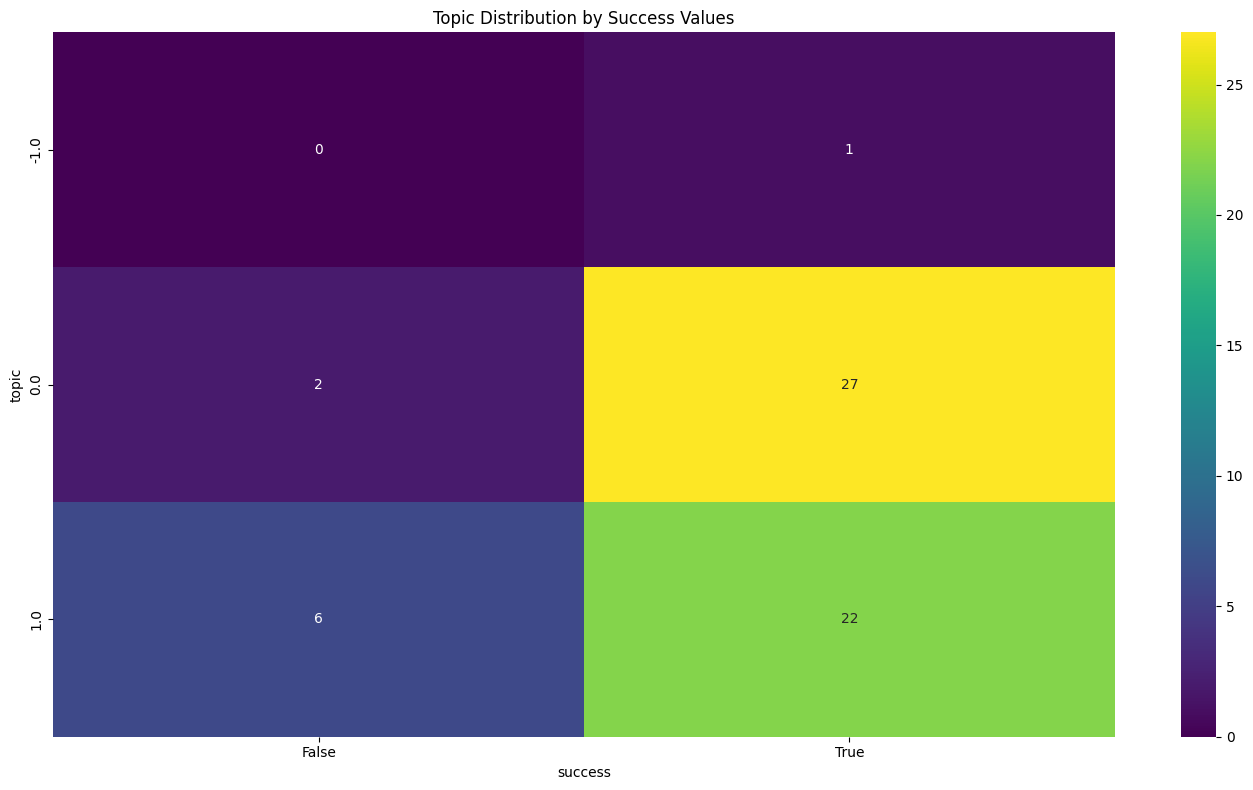

<Figure size 1200x600 with 0 Axes>

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from bertopic import BERTopic
from umap import UMAP
from wordcloud import WordCloud
import plotly.io as pio
from IPython.display import display, HTML

# Configure Plotly to render in notebook
pio.renderers.default = "notebook"

# Set up directory paths dynamically
current_dir = os.path.dirname(os.path.abspath('__file__'))
PROJECT_ROOT = os.path.dirname(current_dir)

# Set paths
DATA_DIR = os.path.join(PROJECT_ROOT, "data", "data1")
PICKLE_PATH = os.path.join(DATA_DIR, "processed_data.pkl")
VIZ_DIR = os.path.join(DATA_DIR, "visualizations", "english")

# Create visualization directory if it doesn't exist
os.makedirs(VIZ_DIR, exist_ok=True)

# Load processed data directly from the pickle file
print("Loading data from pickle file...")
df = pd.read_pickle(PICKLE_PATH)
print(f"Loaded dataframe with {len(df)} rows and {len(df.columns)} columns")

# Extract English text and embeddings
english_text_col = 'english_text_processed'  # Assuming this is the column name
english_embedding_col = 'english_text_embedding'  # Assuming this is the column name

# Extract English text and filter out empty texts
english_corpus = df[english_text_col].fillna("").tolist()
non_empty_indices = [i for i, doc in enumerate(english_corpus) if isinstance(doc, str) and doc.strip() != ""]
filtered_corpus = [english_corpus[i] for i in non_empty_indices]
print(f"Filtered corpus contains {len(filtered_corpus)} non-empty documents")

# Extract pre-computed embeddings directly
raw_embeddings = df[english_embedding_col].tolist()
embeddings = np.array([raw_embeddings[i] for i in non_empty_indices])
print(f"Extracted embeddings with shape {embeddings.shape}")

# Create a BERTopic model with default settings
print("\nCreating and fitting BERTopic model...")
topic_model = BERTopic(
    calculate_probabilities=True,
    verbose=True
)

# Fit the model using precomputed embeddings
topics, probs = topic_model.fit_transform(filtered_corpus, embeddings=embeddings)

# Get topic info
topic_info = topic_model.get_topic_info()
print("\nTop 10 topics by document count:")
display(topic_info[topic_info['Topic'] != -1].sort_values('Count', ascending=False).head(10))

# Generate and display visualizations while also saving to files
print("\nGenerating visualizations...")

# 1. Topic barchart
print("\n1. Topic Barchart")
fig_barchart = topic_model.visualize_barchart(top_n_topics=10, n_words=10)
fig_barchart.write_html(os.path.join(VIZ_DIR, "topic_barchart.html"))
fig_barchart.write_image(os.path.join(VIZ_DIR, "topic_barchart.png"), width=1200, height=800)
display(fig_barchart)

# 2. Topic hierarchy
print("\n2. Topic Hierarchy")
fig_hierarchy = topic_model.visualize_hierarchy(top_n_topics=50)
fig_hierarchy.write_html(os.path.join(VIZ_DIR, "topic_hierarchy.html"))
fig_hierarchy.write_image(os.path.join(VIZ_DIR, "topic_hierarchy.png"), width=1200, height=800)
display(fig_hierarchy)

# 3. Topic network
print("\n3. Topic Network")
fig_network = topic_model.visualize_topics(top_n_topics=20)
fig_network.write_html(os.path.join(VIZ_DIR, "topic_network.html"))
fig_network.write_image(os.path.join(VIZ_DIR, "topic_network.png"), width=1200, height=800)
display(fig_network)

# 4. Topic word clouds
print("\n4. Topic Word Clouds")
# Create a directory for word clouds
wordcloud_dir = os.path.join(VIZ_DIR, "wordclouds")
os.makedirs(wordcloud_dir, exist_ok=True)

# Get top topics
top_topics = topic_info[topic_info['Topic'] != -1].sort_values('Count', ascending=False)['Topic'].head(10).tolist()

# Generate word cloud for each top topic
for topic in top_topics:
    words = topic_model.get_topic(topic)
    if words:
        # Create a dictionary of word:weight pairs
        word_dict = {word: weight for word, weight in words}
        
        # Generate word cloud
        wordcloud = WordCloud(width=800, height=400, background_color='white', 
                             colormap='viridis', max_words=50)
        wordcloud.generate_from_frequencies(word_dict)
        
        # Create figure
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Topic {topic} Word Cloud')
        plt.tight_layout()
        
        # Save figure
        plt.savefig(os.path.join(wordcloud_dir, f"topic_{topic}_wordcloud.png"))
        
        # Display in notebook
        display(plt.gcf())
        plt.close()

print("\nTopic modeling complete!")
print(f"Visualizations saved to: {VIZ_DIR}")